In [1]:
import pandas as pd
import gzip
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
import ast
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords
sns.set()

Usaremos el archivo dfSteamCleaned.csv que creamos en el notebook exploracion_archivos.ipynb.
Recordemos que en ese notebook no modificamos los datos originales, simplemente los extrajimos, desanidamos y convertimos a un formato conveniente.

In [2]:
steam_df = pd.read_csv('dfSteamCleaned.csv')

C:\Users\EnzoTD\AppData\Local\Temp\ipykernel_2892\3235709888.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  steam_df = pd.read_csv('dfSteamCleaned.csv')


In [3]:
steam_df

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120439,Ghost_RUS Games,"['Casual', 'Indie', 'Simulation', 'Strategy']",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"['Strategy', 'Indie', 'Casual', 'Simulation']",http://steamcommunity.com/app/773640/reviews/?...,"['Single-player', 'Steam Achievements']",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0
120440,Sacada,"['Casual', 'Indie', 'Strategy']",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"['Strategy', 'Indie', 'Casual']",http://steamcommunity.com/app/733530/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,0.0,733530.0,Sacada,2018.0
120441,Laush Studio,"['Indie', 'Racing', 'Simulation']",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"['Indie', 'Simulation', 'Racing']",http://steamcommunity.com/app/610660/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0
120442,SIXNAILS,"['Casual', 'Indie']",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...",http://steamcommunity.com/app/658870/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,0.0,658870.0,"xropi,stev3ns",2017.0


In [4]:
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120444 entries, 0 to 120443
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   publisher     24064 non-null   object 
 1   genres        28852 non-null   object 
 2   app_name      32133 non-null   object 
 3   title         30085 non-null   object 
 4   url           32135 non-null   object 
 5   release_date  30068 non-null   object 
 6   tags          31972 non-null   object 
 7   reviews_url   32133 non-null   object 
 8   specs         31465 non-null   object 
 9   price         30758 non-null   object 
 10  early_access  32135 non-null   float64
 11  id            32133 non-null   float64
 12  developer     28836 non-null   object 
 13  year          120444 non-null  float64
dtypes: float64(3), object(11)
memory usage: 12.9+ MB


Tenemos casi 90 mil registros (de un total de 120 mil) que son completamente nulos.

In [5]:
nulos = steam_df.isna().sum()
nulos

publisher       96380
genres          91592
app_name        88311
title           90359
url             88309
release_date    90376
tags            88472
reviews_url     88311
specs           88979
price           89686
early_access    88309
id              88311
developer       91608
year                0
dtype: int64

In [6]:
nulos.nsmallest(2).index

Index(['year', 'url'], dtype='object')

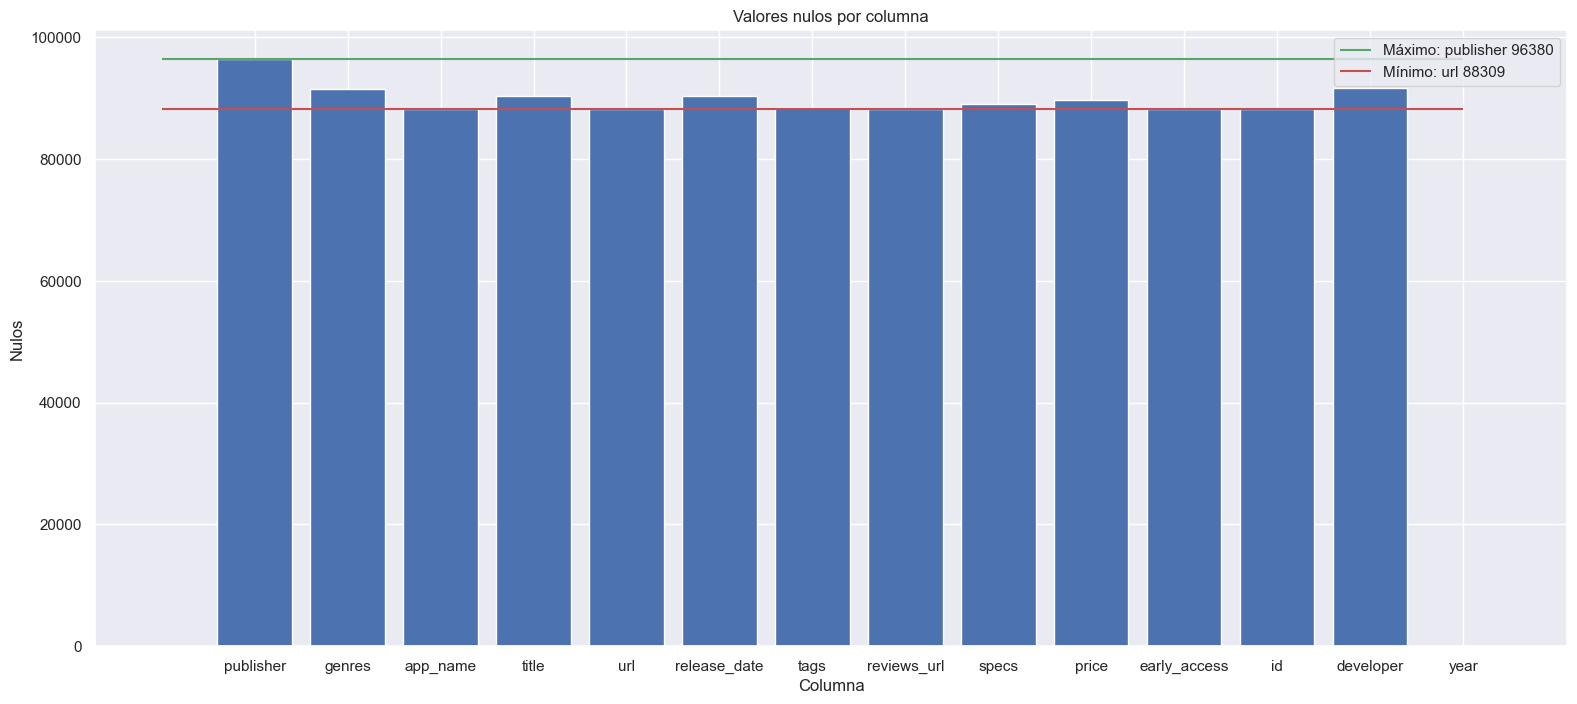

In [7]:
plt.figure(figsize=(19,8))
plt.bar(x=nulos.index, height=nulos.values)
plt.hlines(y=nulos.values.max(),xmax=13, xmin=-1, label=('Máximo: '+nulos.idxmax()+' '+str(nulos.values.max())), colors='g')
plt.hlines(y=nulos.nsmallest(2)[1],xmax=13, xmin=-1, label=('Mínimo: '+nulos.nsmallest(2).index[1]+' '+str(nulos.nsmallest(2)[1])), colors='r')
plt.legend()
plt.xlabel('Columna')
plt.ylabel('Nulos')
plt.title('Valores nulos por columna')
plt.show()

Hay una enorme cantidad de registros nulos. El campo que más valores nulos tiene es 'publisher' con 96380 y los que menos nulos tienen son publisher y early_acces con 88309.

Eliminaremos los registros nulos para continuar con el análisis.

In [8]:
columna_sin_nulos = ['year']
columnas_con_nulos = steam_df.columns.difference(columna_sin_nulos)
columnas_con_nulos

Index(['app_name', 'developer', 'early_access', 'genres', 'id', 'price',
       'publisher', 'release_date', 'reviews_url', 'specs', 'tags', 'title',
       'url'],
      dtype='object')

In [9]:
steam_df.dropna(subset=columnas_con_nulos, inplace=True)

In [10]:
del(columna_sin_nulos,columnas_con_nulos)

In [11]:
steam_df.describe()

,early_access,id,year
count,22511.000000,2.251100e+04,22511.000000
mean,0.060326,4.306731e+05,2014.489405
std,0.238095,1.918832e+05,19.312257
min,0.000000,1.000000e+01,0.000000
25%,0.000000,3.022250e+05,2014.000000
50%,0.000000,4.269270e+05,2016.000000
75%,0.000000,5.807050e+05,2017.000000
max,1.000000,2.028850e+06,2021.000000


Al utilizar el método describe vemos que la columna price no aparece en el informe. Seguramente se debe a que tiene un tipo de dato incorrecto.
Esto se nos pasó por alto en el notebook exploracion_archivos.

In [12]:
steam_df['price'].unique()

array(['4.99', 'Free To Play', 'Free to Play', '0.99', '3.99', '18.99',
       '29.99', '10.99', '2.99', '1.5899999999999999', '14.99', '1.99',
       '59.99', '9.99', '6.99', '7.99', '39.99', 'Free', '19.99', '7.49',
       '8.99', '12.99', '5.99', '2.49', '15.99', '1.25', '24.99', '17.99',
       '61.99', '3.49', '11.99', '13.99', 'Free Demo', 'Play for Free!',
       '34.99', '1.49', '32.99', '99.99', '14.95', '69.99', '16.99',
       '79.99', '49.99', '13.98', '149.99', '771.71', 'Install Now',
       '21.99', '89.99', 'Play WARMACHINE: Tactics Demo', '0.98',
       '139.92', '4.29', 'Free Mod', '54.99', '64.99', '74.99', '0.89',
       '0.5', 'Play Now', '299.99', '1.29', '119.99', '44.99', '3.0',
       '15.0', '1.3900000000000001', 'Free HITMAN™ Holiday Pack', '2.0',
       '4.0', '1.9500000000000002', '1.5', '6.66', '26.99', '399.99',
       '31.99', '20.0', '40.0', '5.0', '3.33', '38.85', '71.7', '995.0',
       '5.49', '27.49', '3.39', '6.0', '19.95', '20.99', '499.99',
     

Reemplazamos los valores textuales por 0.0

In [13]:
steam_df['price'] = steam_df['price'].replace(['Free To Play', 'Free', 'Free Demo', 'Install Now', 'Play Now', 'Third-party', 'Free to Play', 'Play for Free!','Play WARMACHINE: Tactics Demo','Free Mod','Free HITMAN™ Holiday Pack','Play the Demo'], '0.0')

Convertimos los datos a float y formateamos a dos decimales

In [14]:
steam_df['price'] = pd.to_numeric(steam_df['price'], errors='coerce')
steam_df['price'] = steam_df['price'].apply(lambda x: round(x,2))

In [15]:
type(steam_df['price'].iloc[0])

numpy.float64

In [16]:
#ahora tenemos la descripción de los precios con sus respectivos máximos y mínimos
steam_df.describe()

,price,early_access,id,year
count,22511.000000,22511.000000,2.251100e+04,22511.000000
mean,8.971609,0.060326,4.306731e+05,2014.489405
std,15.423713,0.238095,1.918832e+05,19.312257
min,0.000000,0.000000,1.000000e+01,0.000000
25%,2.990000,0.000000,3.022250e+05,2014.000000
50%,4.990000,0.000000,4.269270e+05,2016.000000
75%,9.990000,0.000000,5.807050e+05,2017.000000
max,995.000000,1.000000,2.028850e+06,2021.000000


De la descripción estadística de los precios vemos que el 75% de los precios está por debajo de los 10 dólares. Sin embargo, el precio máximo son casi mil dólares.
Eso nos hace sospechar que quizás se trata de un outlier.

In [17]:
precios_altos = steam_df[(steam_df['price']>=100)]
precios_altos

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year
90644,"Trion Worlds, Inc.","['Free to Play', 'Massively Multiplayer', 'RPG']",RIFT: Laethys' Fortune Pack,RIFT: Laethys' Fortune Pack,http://store.steampowered.com/app/310300/RIFT_...,2014-06-19,"['Free to Play', 'RPG', 'Massively Multiplayer']",http://steamcommunity.com/app/310300/reviews/?...,"['Single-player', 'Multi-player', 'MMO', 'Co-o...",149.99,0.0,310300.0,Trion Worlds,2014.0
90701,Aerosoft GmbH,['Simulation'],X-Plane 10 Global - 64 Bit,X-Plane 10 Global - 64 Bit,http://store.steampowered.com/app/292180/XPlan...,2014-07-14,"['Simulation', 'Flight', 'Realistic', 'Open Wo...",http://steamcommunity.com/app/292180/reviews/?...,"['Single-player', 'Multi-player', 'Cross-Platf...",771.71,0.0,292180.0,Laminar Research,2014.0
91568,GameUS Inc.,"['Action', 'Casual', 'Free to Play', 'RPG', 'S...",HIS (Heroes In the Sky),HIS (Heroes In the Sky),http://store.steampowered.com/app/342570/HIS_H...,2015-03-03,"['Free to Play', 'Action', 'Multiplayer', 'Fli...",http://steamcommunity.com/app/342570/reviews/?...,"['Single-player', 'Multi-player', 'Co-op', 'Pa...",139.92,0.0,342570.0,GameUS Inc.,2015.0
92754,The Foundry,"['Animation &amp; Modeling', 'Design &amp; Ill...",MODO indie 10,MODO indie 10,http://store.steampowered.com/app/401090/MODO_...,2015-09-24,"['Animation & Modeling', 'Design & Illustration']",http://steamcommunity.com/app/401090/reviews/?...,['Steam Cloud'],299.99,0.0,401090.0,The Foundry,2015.0
93015,The Game Creators,"['Animation &amp; Modeling', 'Design &amp; Ill...",The Official AppGameKit Tutorial Guide Vol 1,The Official AppGameKit Tutorial Guide Vol 1,http://store.steampowered.com/app/345720/The_O...,2015-10-30,"['Design & Illustration', 'Utilities', 'Animat...",http://steamcommunity.com/app/345720/reviews/?...,['Downloadable Content'],119.99,0.0,345720.0,"Digital Skills,The Game Creators",2015.0
97383,YoYo Games Ltd.,"['Animation &amp; Modeling', 'Design &amp; Ill...",GameMaker Studio 2 Mobile,GameMaker Studio 2 Mobile,http://store.steampowered.com/app/585620/GameM...,2017-03-08,"['Game Development', 'Design & Illustration', ...",http://steamcommunity.com/app/585620/reviews/?...,['In-App Purchases'],399.99,0.0,585620.0,YoYo Games Ltd.,2017.0
97384,YoYo Games Ltd.,"['Animation &amp; Modeling', 'Design &amp; Ill...",GameMaker Studio 2 UWP,GameMaker Studio 2 UWP,http://store.steampowered.com/app/585610/GameM...,2017-03-08,"['Game Development', 'Design & Illustration', ...",http://steamcommunity.com/app/585610/reviews/?...,['In-App Purchases'],399.99,0.0,585610.0,YoYo Games Ltd.,2017.0
97385,YoYo Games Ltd.,"['Animation &amp; Modeling', 'Design &amp; Ill...",GameMaker Studio 2 Web,GameMaker Studio 2 Web,http://store.steampowered.com/app/585600/GameM...,2017-03-08,"['Game Development', 'Design & Illustration', ...",http://steamcommunity.com/app/585600/reviews/?...,['In-App Purchases'],149.99,0.0,585600.0,YoYo Games Ltd.,2017.0
97783,my.com,"['Free to Play', 'Massively Multiplayer', 'RPG']",Skyforge - Costume Booster Pack,Skyforge - Costume Booster Pack,http://store.steampowered.com/app/546374/Skyfo...,2017-04-13,"['Free to Play', 'RPG', 'Massively Multiplayer']",http://steamcommunity.com/app/546374/reviews/?...,"['Single-player', 'Multi-player', 'MMO', 'Down...",119.99,0.0,546374.0,Allods Team,2017.0
98107,3Dflow SRL,"['Animation &amp; Modeling', 'Design &amp; Ill...",3DF Zephyr Lite Steam Edition,3DF Zephyr Lite Steam Edition,http://store.steampowered.com/app/438450/3DF_Z...,2016-02-02,"['Video Production', 'Animation & Modeling', '...",http://steamcommunity.com/app/438450/reviews/?...,['Steam Trading Cards'],149.99,0.0,438450.0,3Dflow SRL,2016.0


Después de una breve búsqueda por internet, podremos ver que el único valor que parece ser incorrecto es el del item 292180. El precio en el listado de steam figura como 771 dólares. Mientras que en las pas tiendas virtuales figura alrededor de los 70 dólares (en steam no hay información sobre su precio). Podríamos modificarlo a 70 dólares.

In [18]:
steam_df.loc[steam_df['price']==771.71,'price']=70

In [19]:
steam_df[(steam_df['app_name']=='X-Plane 10 Global - 64 Bit')]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year
90701,Aerosoft GmbH,['Simulation'],X-Plane 10 Global - 64 Bit,X-Plane 10 Global - 64 Bit,http://store.steampowered.com/app/292180/XPlan...,2014-07-14,"['Simulation', 'Flight', 'Realistic', 'Open Wo...",http://steamcommunity.com/app/292180/reviews/?...,"['Single-player', 'Multi-player', 'Cross-Platf...",70.0,0.0,292180.0,Laminar Research,2014.0


In [20]:
del(precios_altos)

Desanidaremos los géneros para buscar alguna correlación entre el género y las otras variables.

In [21]:
type(steam_df['genres'].iloc[0])

str

Convertimos los str que contienen las listas de géneros a listas verdaderas.

In [22]:
steam_df['genres'] = steam_df['genres'].apply(ast.literal_eval)

Cuando explotemos la columna de los géneros la cantidad de registros en el dataframe va aumentar abruptamente. Para reducir un poco el consumo de recuros vamos a separar la columna genres y price en un dataframe aparte.

In [23]:
precio_genero = steam_df[['genres','price']]
precio_genero = precio_genero.explode('genres')
precio_genero

,genres,price
88309,Action,4.99
88309,Casual,4.99
88309,Indie,4.99
88309,Simulation,4.99
88309,Strategy,4.99
...,...,...
120441,Indie,1.99
120441,Racing,1.99
120441,Simulation,1.99
120442,Casual,4.99


In [24]:
maximo_por_genero = precio_genero.groupby('genres')['price'].max()

In [25]:
promedio_genero = precio_genero.groupby('genres')['price'].mean()
promedio_genero

genres
Action                        8.103302
Adventure                     8.017415
Animation &amp; Modeling     78.074940
Audio Production             20.857000
Casual                        5.669170
Design &amp; Illustration    32.005682
Early Access                 10.088233
Education                    74.103774
Free to Play                  9.591690
Indie                         6.704575
Massively Multiplayer        16.650789
Photo Editing                32.627273
RPG                          10.134354
Racing                        8.341109
Simulation                   11.073087
Software Training            31.601944
Sports                       10.349457
Strategy                      8.957036
Utilities                    43.278705
Video Production             31.934444
Web Publishing               28.185077
Name: price, dtype: float64

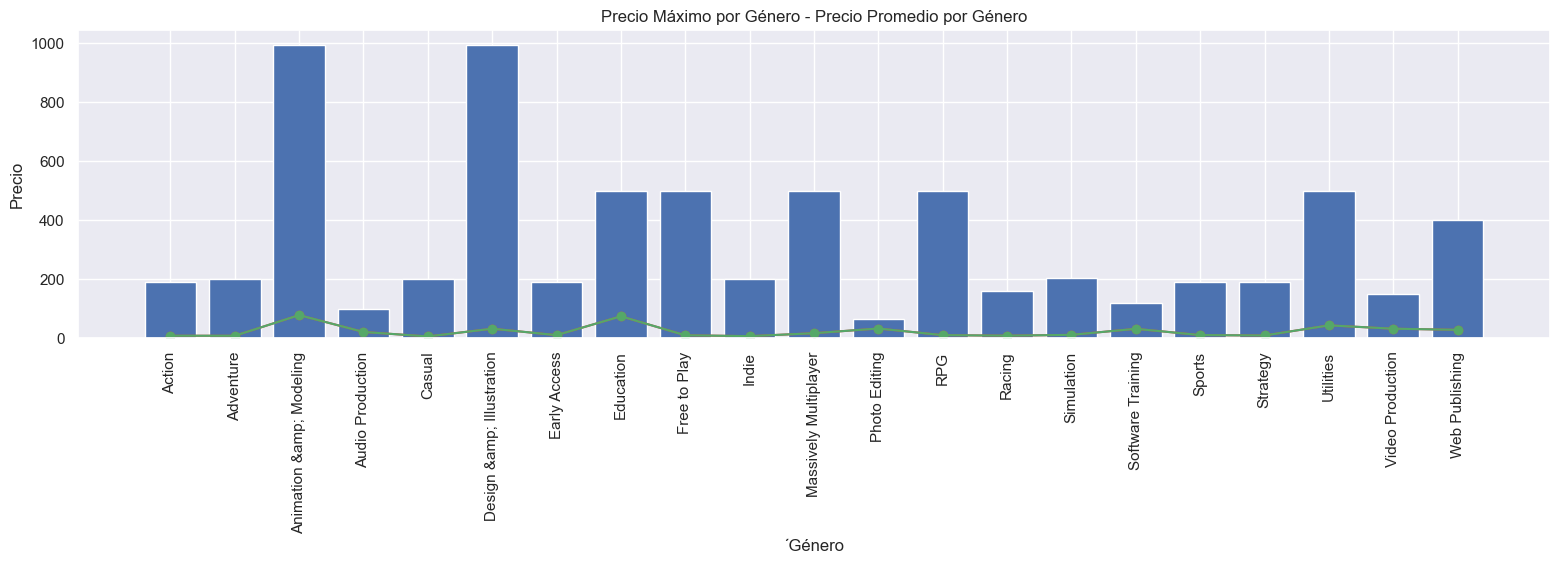

In [26]:
plt.figure(figsize=(19,4))
plt.bar(x=maximo_por_genero.index, height=maximo_por_genero.values)
plt.plot(maximo_por_genero.index, promedio_genero.values, marker='o', linestyle='-', color='r')
plt.plot(promedio_genero.index, promedio_genero.values, marker='o', linestyle='-', color='g')
plt.title('Precio Máximo por Género - Precio Promedio por Género')
plt.xlabel('´Género')
plt.ylabel('Precio')
plt.xticks(rotation=90)
plt.show()

In [27]:
del(precio_genero,promedio_genero,maximo_por_genero)

Analicemos ahora la columna de los años

Vemos los rangos máximos de los años, ignoraremos los registros con un año igual a 0.

In [28]:
year_no_nulo = steam_df[(steam_df['year']!=0)]

In [29]:
print(year_no_nulo['year'].max(), year_no_nulo['year'].min())

2021.0 1983.0


Tenemos registros desde 1983 hasta 2021

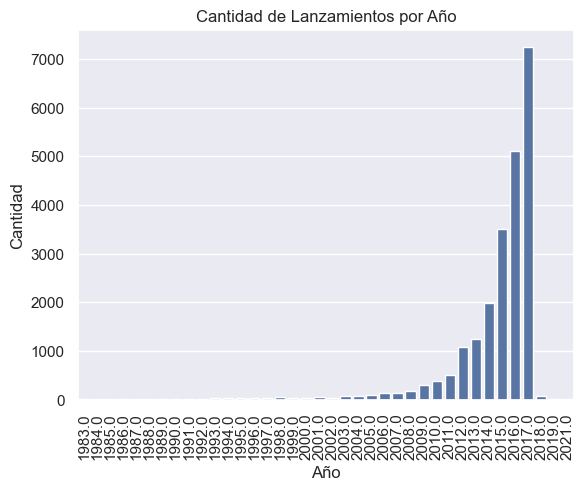

In [30]:
sns.countplot(data=year_no_nulo, x='year')
plt.title('Cantidad de Lanzamientos por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.show()

Ahora con las fechas y los precios en el formato adecuado, vamos a analizar un poco los outliers.

Cómo vemos en estos gráficos, visualizar la información es complicado debido a la gran diferencia entre el valor máximo y el mínimo. Sin embargo, no sería prudente eliminar los outliers ya que no podemos asegurar que realmente se trate de un error, además, representan el 25% de los datos que es un porcentaje significativo.

In [31]:
filtered_years=steam_df[(steam_df['year'])>=2005]

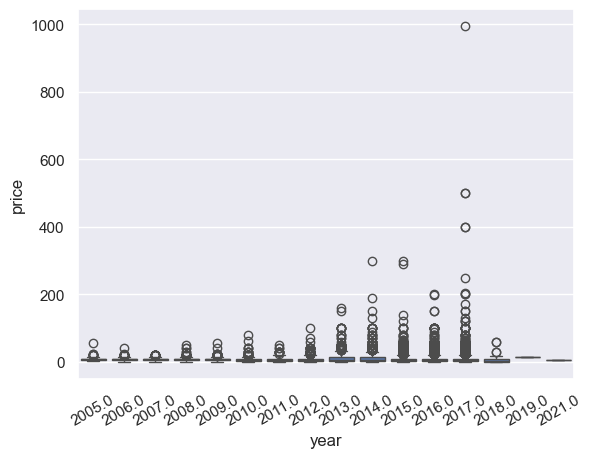

In [32]:
sns.boxplot(x=filtered_years['year'],y=steam_df['price'])
plt.xticks(rotation=30)
plt.show()

In [ ]:
del(precios_promedios, registros_con_nulos)

Ya no quedan nulos, ahora podemos calcular el zscore para tratar los outliers.

In [ ]:
steam_df['price'].isna().sum()

0

In [ ]:
steam_df['z_score']=zscore(steam_df['price'])

La función zscore nos dice cuántas desviaciones estandar se aparta un valor de su promedio. Los valores que tengan un zscore mayor o igual a 3 son considerados outliers. Si bien el zscore se utiliza para distribuciones normales (que no es este caso) aún podemos utilizarla para saber cuánto se aparta un dato respecto del promedio.

In [ ]:
steam_df[(steam_df['z_score']>=3)]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year,z_score
88327,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - Lifetime Pack,SNOW - Lifetime Pack,http://store.steampowered.com/app/774279/SNOW_...,2018-01-03,"[Free to Play, Indie, Simulation, Sports]",http://steamcommunity.com/app/774279/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",59.99,0.0,774279.0,Poppermost Productions,2018.0,3.137629
88734,SEGA,"[Action, Adventure, Casual, RPG]",SEGA Mega Drive and Genesis Classics,SEGA Mega Drive and Genesis Classics,http://store.steampowered.com/app/34270/SEGA_M...,2010-06-01,"[Action, RPG, Casual, Adventure, Retro, Classic]",http://steamcommunity.com/app/34270/reviews/?b...,"[Single-player, Multi-player, Co-op, Local Co-...",61.99,0.0,34270.0,D3T Limited,2010.0,3.260441
89403,Pilgway,[Animation &amp; Modeling],3D-Coat V4.8,3D-Coat V4.8,http://store.steampowered.com/app/100980/3DCoa...,2012-10-02,[Animation & Modeling],http://steamcommunity.com/app/100980/reviews/?...,[Steam Cloud],99.99,0.0,100980.0,Pilgway,2012.0,5.593869
89487,Activision,[Action],Call of Duty®: Black Ops II,Call of Duty®: Black Ops II,http://store.steampowered.com/app/202970/Call_...,2012-11-12,"[Action, Multiplayer, FPS, Shooter, First-Pers...",http://steamcommunity.com/app/202970/reviews/?...,"[Single-player, Multi-player, Co-op, Steam Ach...",59.99,0.0,202970.0,Treyarch,2012.0,3.137629
89562,THQ Nordic,[Action],Painkiller Hell & Damnation: Satan Claus DLC,Painkiller Hell &amp; Damnation: Satan Claus DLC,http://store.steampowered.com/app/219136/Paink...,2013-01-17,[Action],http://steamcommunity.com/app/219136/reviews/?...,"[Single-player, Multi-player, Co-op, Shared/Sp...",69.99,0.0,219136.0,The Farm 51,2013.0,3.751689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118333,SEGA,[Strategy],Total War™: ROME II - Emperor Edition,Total War™: ROME II - Emperor Edition,http://store.steampowered.com/app/214950/Total...,2013-09-02,"[Strategy, Historical, Turn-Based Strategy, Gr...",http://steamcommunity.com/app/214950/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",59.95,0.0,214950.0,Creative Assembly,2013.0,3.135173
118627,Gaijin Entertainment,"[Action, Free to Play, Massively Multiplayer, ...",Star Conflict: Mercenary Pack - Elite Pilot,Star Conflict: Mercenary Pack - Elite Pilot,http://store.steampowered.com/app/222282/Star_...,2013-02-27,"[Action, Free to Play, Massively Multiplayer, ...",http://steamcommunity.com/app/222282/reviews/?...,"[Multi-player, MMO, Downloadable Content, Part...",79.99,0.0,222282.0,Star Gem Inc.,2013.0,4.365749
118662,"Sector3 Studios, RaceRoom Entertainment AG","[Free to Play, Racing, Simulation, Sports]",RaceRoom Racing Experience,RaceRoom Racing Experience,http://store.steampowered.com/app/211500/RaceR...,2013-02-12,"[Racing, Free to Play, Multiplayer, Simulation...",http://steamcommunity.com/app/211500/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",160.91,0.0,211500.0,Sector3 Studios,2013.0,9.334722
118760,Nevercenter Ltd. Co.,[Animation &amp; Modeling],Silo 2,Silo 2,http://store.steampowered.com/app/100400/Silo_2/,2012-12-19,"[Animation & Modeling, Software]",http://steamcommunity.com/app/100400/reviews/?...,None,99.99,0.0,100400.0,Nevercenter Ltd. Co.,2012.0,5.593869


In [ ]:
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29967 entries, 88309 to 120442
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     23969 non-null  object 
 1   genres        28733 non-null  object 
 2   app_name      29966 non-null  object 
 3   title         29966 non-null  object 
 4   url           29967 non-null  object 
 5   release_date  29967 non-null  object 
 6   tags          29806 non-null  object 
 7   reviews_url   29966 non-null  object 
 8   specs         29298 non-null  object 
 9   price         29967 non-null  float64
 10  early_access  29967 non-null  float64
 11  id            29966 non-null  float64
 12  developer     28717 non-null  object 
 13  year          29967 non-null  float64
 14  z_score       29967 non-null  float64
dtypes: float64(5), object(10)
memory usage: 3.7+ MB


Con el criterio del zscore>=3 tenemos 288 valores atípicos de un total de 29967. Es decir, menos del 1 por ciento.

In [ ]:
len(steam_df[(steam_df['z_score']>=3)])/len(steam_df)*100

0.9610571628791672

In [ ]:
steam_df[(steam_df['year']==2017)]['price'].mean()

8.99217571884984

In [ ]:
steam_df[(steam_df['year']==2017)]['price'].mode().iloc[0]

4.99

Con un porcentaje tan chico de valores atípicos no deberíamos tener problemas en hacer un análisis general sin considerar dichos valores atípicos. Como no podemos asegurar que los outliers se traten de errores en los datos, no sería prudente eliminarlos ya que podríamos perder información verídica. Por ejemplo, el item más caro corresponde al año 2017 y tiene un precio de 995 dólares y el promedio y la moda para el mismo año son de 8.99 dólares y 4.99 dólares respectivamente. Esto nos podría hacer pensar que se trata de un error, sin embargo, consultando en internet podemos ver que el precio realmente fue de 995 dólares. 

Por este motivo lo que haremos será un análisis general con los precios pero sin tener en cuenta estos casos particulares.

Vamos a analizar los items del 2005 en adelante ya que son los años con mayor cantidad de registros y por lo tanto los que más información relevante pueden tener.

In [ ]:
no_outliers_prices=steam_df[(abs(steam_df['z_score']))<3 & (steam_df['year']>=2005.0)]
no_outliers_prices

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year,z_score
88309,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0.0,761140.0,Kotoshiro,2018.0,-0.239700
88310,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,2018.0,-0.546116
88311,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,2017.0,-0.546116
88312,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,0.0,767400.0,彼岸领域,2017.0,-0.485324
88314,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",http://steamcommunity.com/app/772540/reviews/?...,"[Single-player, Steam Achievements]",3.99,0.0,772540.0,Trickjump Games Ltd,2018.0,-0.301106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120438,Bidoniera Games,"[Action, Adventure, Casual, Indie]",Kebab it Up!,Kebab it Up!,http://store.steampowered.com/app/745400/Kebab...,2018-01-04,"[Action, Indie, Casual, Violent, Adventure]",http://steamcommunity.com/app/745400/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",1.99,0.0,745400.0,Bidoniera Games,2018.0,-0.423918
120439,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0,-0.423918
120440,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada,2018.0,-0.239700
120441,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0,-0.423918


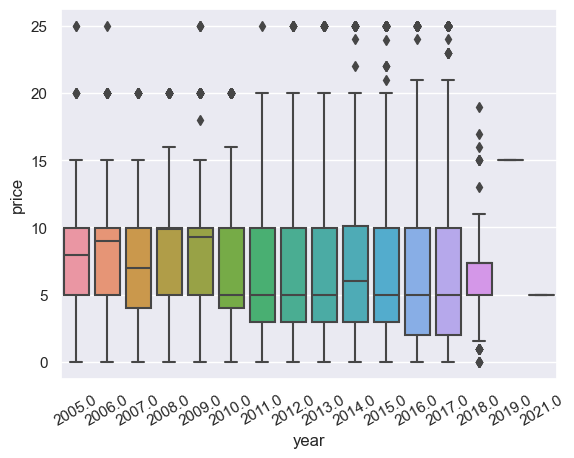

In [ ]:
sns.boxplot(x=no_outliers_prices['year'], y=no_outliers_prices['price'])
plt.xticks(rotation=30)
plt.show()

In [ ]:
precio_promedio_anual=no_outliers_prices.groupby('year')['price'].mean().reset_index()

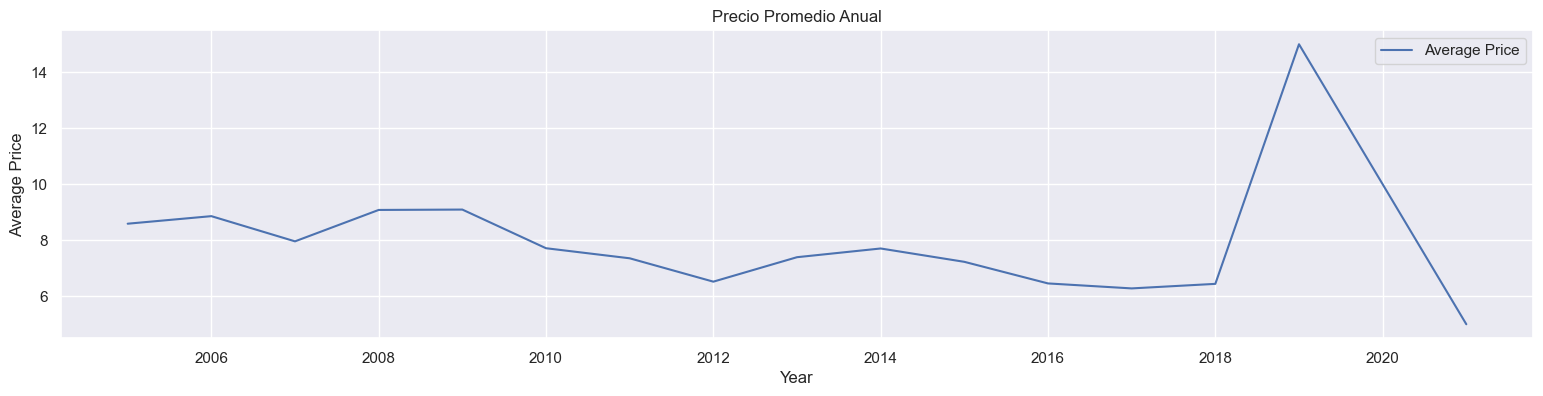

In [ ]:
plt.figure(figsize=(19,4))
plt.plot(precio_promedio_anual['year'], precio_promedio_anual['price'], label='Average Price')
plt.title('Precio Promedio Anual')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
del(precio_promedio_anual)

Sería lógico pensar que el precio promedio de los juegos tuvo una caída abrupta durante el 2020 basándonos en el gráfico y recordando que ese año fue la pandemia de CoViD-19.
Pero en realidad no tenemos registros que nos aporten información para el año 2020 y para el 2021 tenemos solo un registro.
Por lo tanto los análisis que podamos hacer serán confiables hasta el año 2019.

In [ ]:
steam_df[(steam_df['year']==2021.0)]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year,z_score
101449,Freebird Games,"[Adventure, Indie, RPG]",Finding Paradise Soundtrack,Finding Paradise Soundtrack,http://store.steampowered.com/app/770780/Findi...,2021-12-31,"[Adventure, RPG, Indie]",http://steamcommunity.com/app/770780/reviews/?...,"[Single-player, Downloadable Content]",4.99,0.0,770780.0,Freebird Games,2021.0,-0.2397


Veamos cuántos desarrolladores hay.

In [ ]:
developers=steam_df['developer'].unique()
len(developers)
#hay casi 11 mil desarrolladores

10923

Veamos cuántos juegos tenemos por cada desarrollador

In [ ]:
games_per_developers=steam_df['developer'].value_counts()
games_per_developers

Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
                              ... 
Ilex Games                       1
Outlaw,Douglas Brantes           1
Ionel Zeveleanu                  1
Shadow Blade Productions         1
Bidoniera Games                  1
Name: developer, Length: 10922, dtype: int64

Graficamos los números para una mejor interpretación

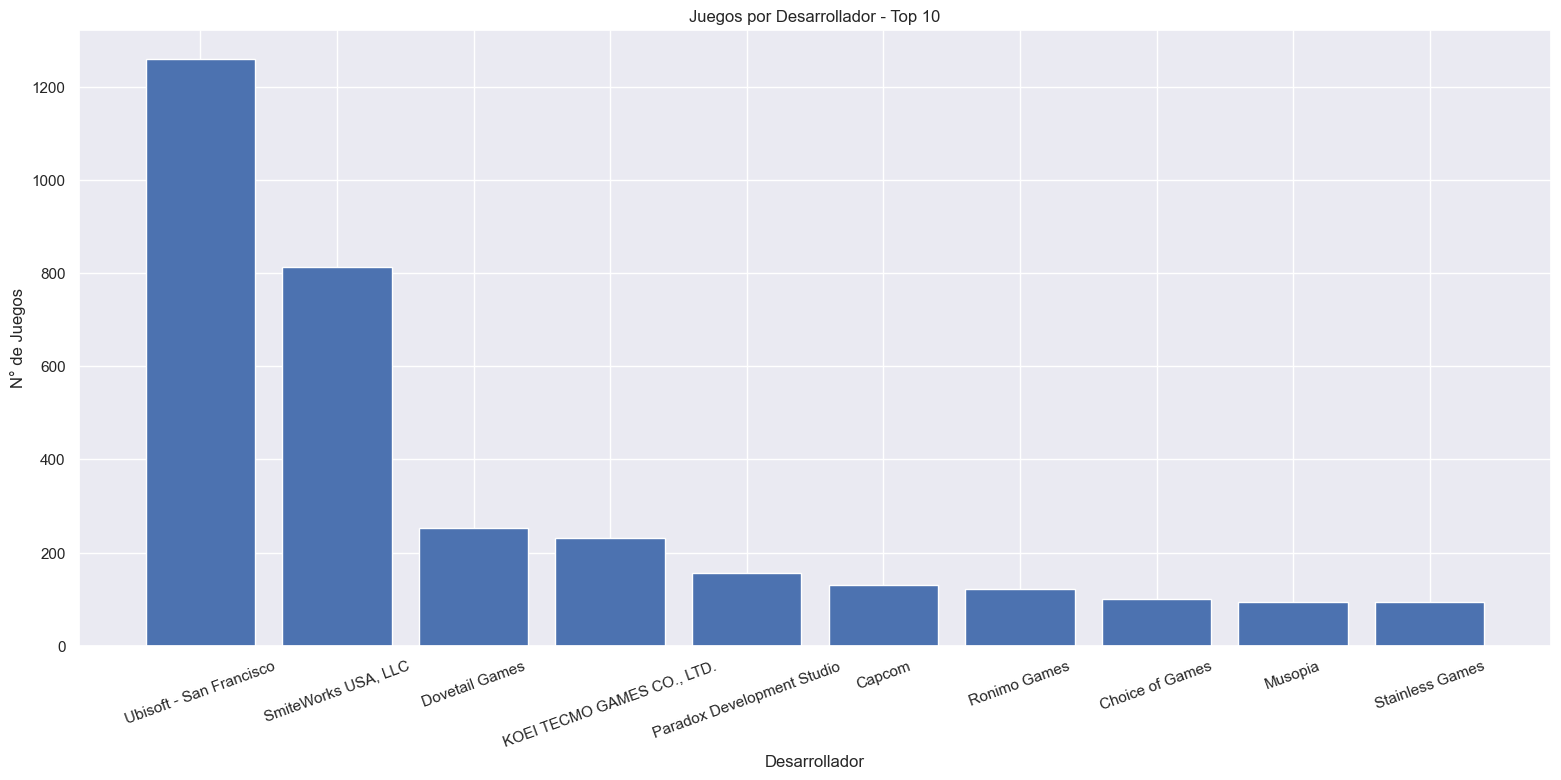

In [ ]:
plt.figure(figsize=(19,8))
plt.bar(x=games_per_developers.index[:10], height=games_per_developers.values[:10])
plt.xticks(rotation=20)
plt.xlabel('Desarrollador')
plt.ylabel('N° de Juegos')
plt.title('Juegos por Desarrollador - Top 10')
plt.show()

En un gráfico circular vemos los 5 desarrolladores con la mayor cantidad de juegos.

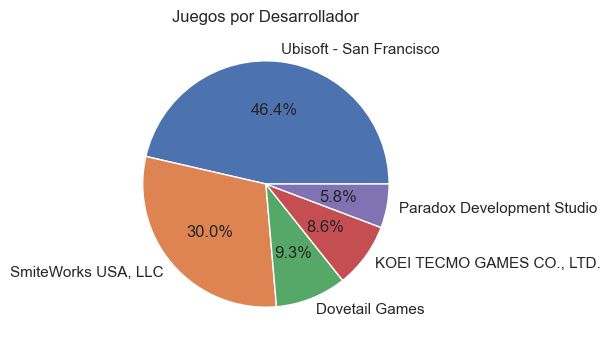

In [ ]:
plt.figure(figsize=(10,4))
plt.pie(x=games_per_developers[:5], autopct='%1.1f%%', labels=games_per_developers.index[:5])
plt.title('Juegos por Desarrollador')
plt.show()

In [ ]:
precio_promedio_developer=no_outliers_prices.groupby('developer')['price'].mean().reset_index()
precio_promedio_developer=precio_promedio_developer.sort_values(by='price', ascending=False)
precio_promedio_developer

,developer,price
929,Bankroll Studios,24.99
781,Atomicom,24.99
5190,Lion Game Lion,24.99
5757,Mindillusion,24.99
8141,SoftPlanet,24.99
...,...,...
502,"Amidos,Big O",0.00
8812,Teeworlds Team,0.00
3353,Fork Particle Games,0.00
5183,"Linden Research, Inc.",0.00


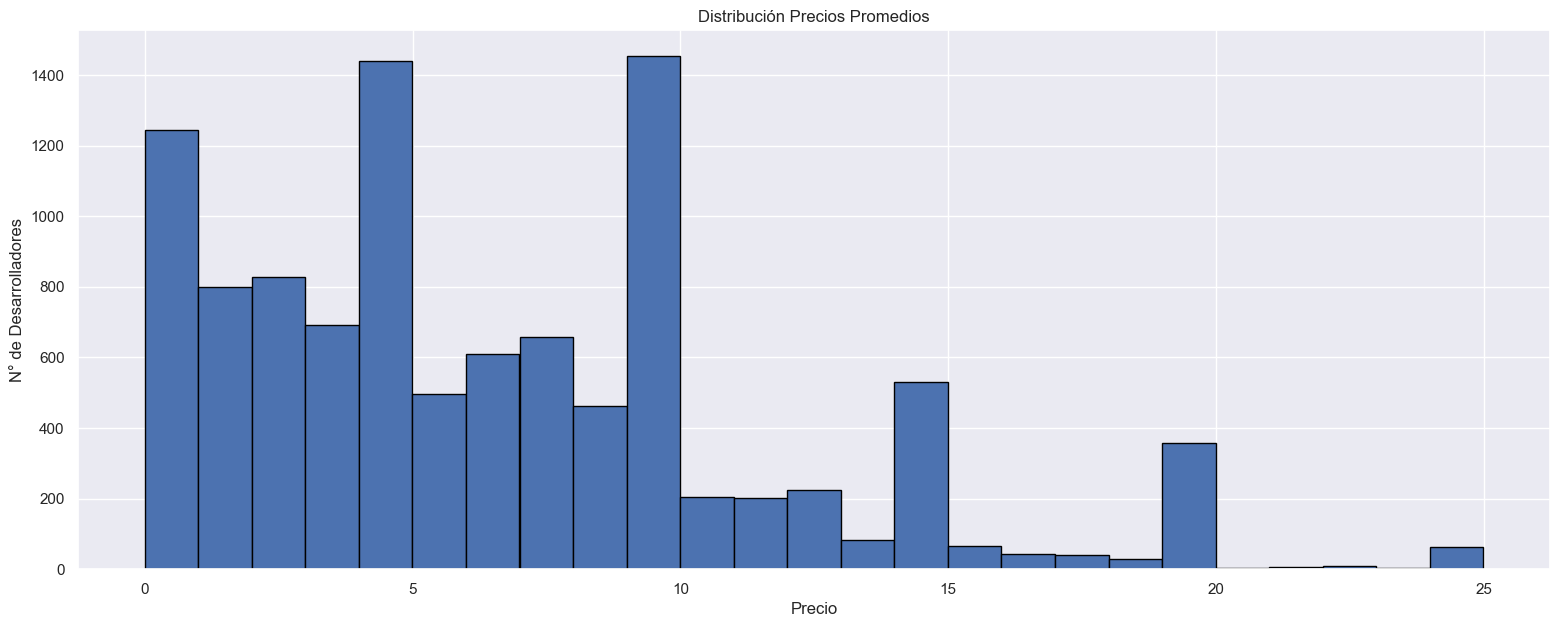

In [ ]:
plt.figure(figsize=(19,7))
plt.hist(precio_promedio_developer['price'], bins=25, edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('N° de Desarrolladores')
plt.title('Distribución Precios Promedios')
plt.show()

In [ ]:
del(games_per_developers,developers)

Cantidad de lanzamientos por año.

In [ ]:
games_per_year=steam_df['year'].value_counts()
games_per_year.index

Float64Index([2017.0, 2016.0, 2015.0, 2014.0, 2013.0, 2012.0, 2011.0, 2010.0,
              2009.0, 2008.0, 2007.0, 2018.0, 2006.0, 2005.0, 2003.0, 2004.0,
              2001.0, 1998.0, 1999.0, 2002.0, 1997.0, 2000.0, 1996.0, 1994.0,
              1993.0, 1995.0, 1991.0, 1992.0, 1990.0, 1989.0, 1987.0, 1988.0,
              1984.0, 1983.0, 2019.0, 1985.0, 1982.0, 1981.0, 1970.0, 1986.0,
              2021.0, 1975.0, 1980.0],
             dtype='float64')

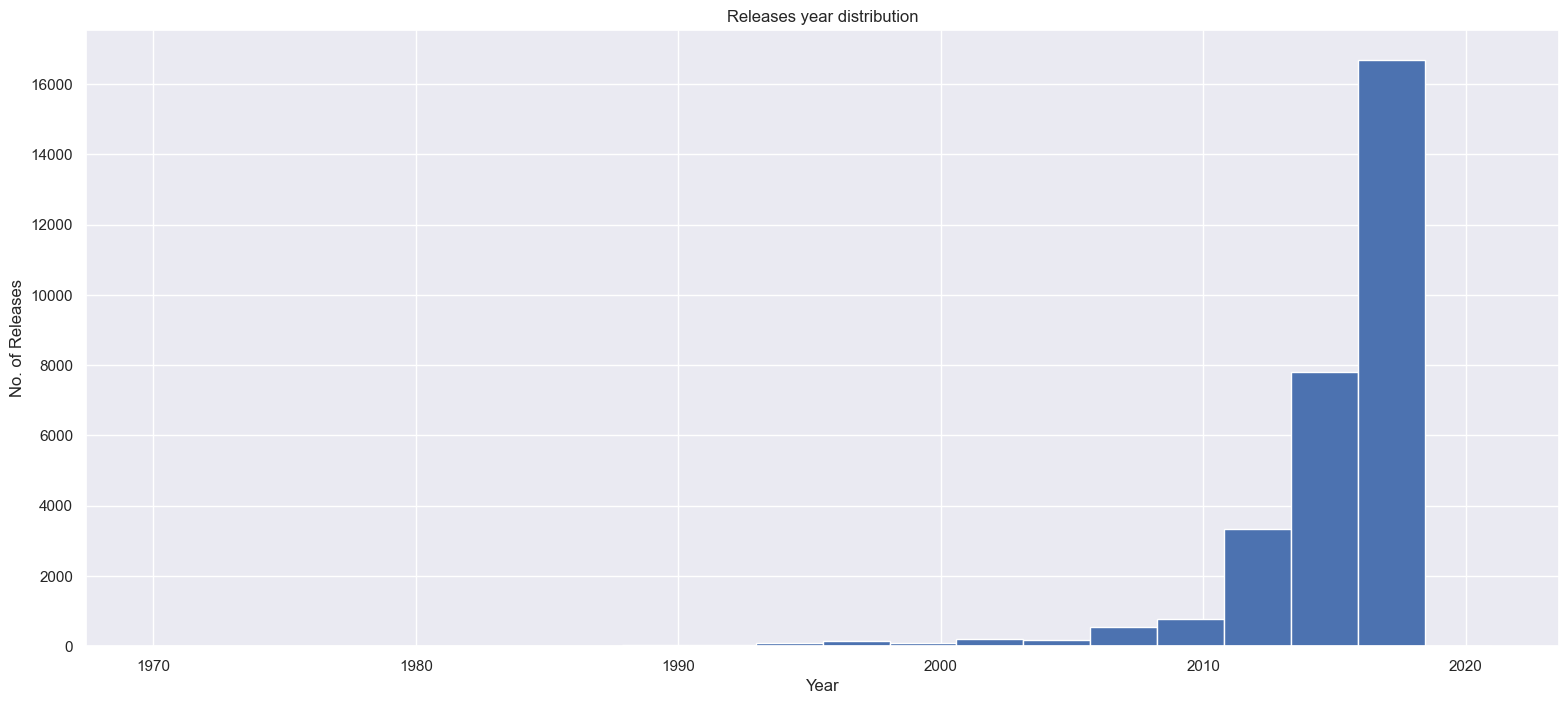

In [ ]:
plt.figure(figsize=(19,8))
plt.hist(steam_df['year'], bins=20)
plt.title('Releases year distribution')
plt.xlabel('Year')
plt.ylabel('No. of Releases')
plt.show()

Como dijimos anteriormente podemos ver que la mayoría de los juegos se lanzaron a partir del 2010 y que no hay una cantidad significativa de lanzamientos registrados para el año 2021.

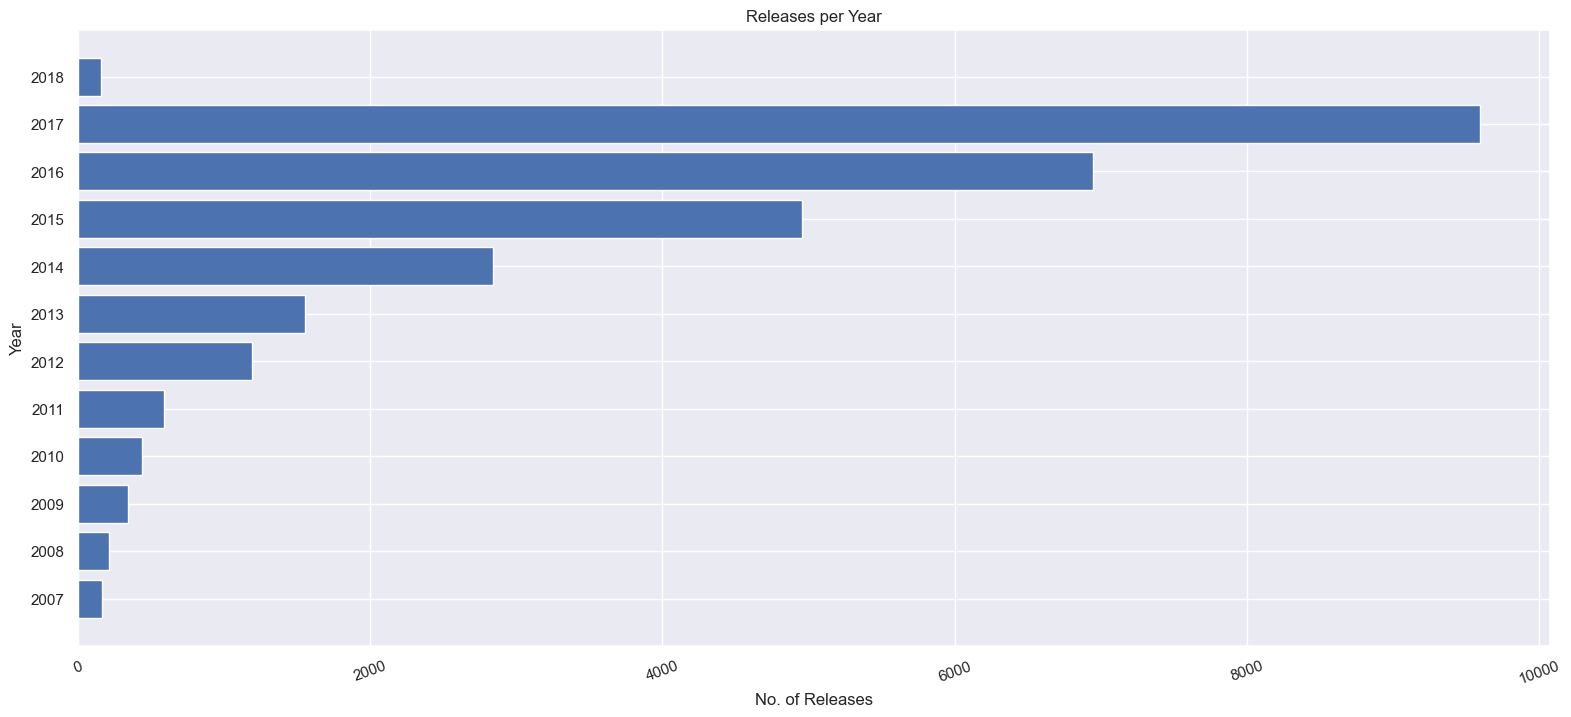

In [ ]:
plt.figure(figsize=(19,8))
plt.barh(y=games_per_year.index[:12], width=games_per_year.values[:12])
plt.xlabel('No. of Releases')
plt.ylabel('Year')
plt.xticks(rotation=20)
plt.yticks(games_per_year.index[:12])
plt.title('Releases per Year')
plt.show()

In [ ]:
del(games_per_year)

Veamos la cantidad de juegos lanzados por cada desarrollador por año.

In [ ]:
developers_per_year_df=steam_df[['year','developer']]

In [ ]:
count_per_year_per_developer = developers_per_year_df.groupby(['year', 'developer']).size().reset_index(name='count')
count_per_year_per_developer

,year,developer,count
0,1983.0,Digital Leisure Inc.,1
1,1984.0,Digital Leisure Inc.,1
2,1984.0,"Ed Hobbs,Robert Crossfield",1
3,1985.0,"MicroProse Software, Inc",1
4,1986.0,Choose Multiple LLC,1
...,...,...,...
14926,2019.0,Ninetales Studios,1
14927,2019.0,Nodding Heads Games,1
14928,2019.0,Poetic Justice Studios,1
14929,2019.0,Svarun Entertainment,1


In [ ]:
count_per_year_per_developer=count_per_year_per_developer.sort_values(by=['year','count'], ascending=[True,False])

Como son demasiados registros consideraremos desde el año 2010 en adelante.

In [ ]:
count_per_year_per_developer_filtered=count_per_year_per_developer[count_per_year_per_developer['year']>=2010.0]

Para cada año tomamos los 5 desarrolladores con la mayor cantidad de juegos.

In [ ]:
top3_per_year = count_per_year_per_developer_filtered.groupby('year').head(3)

In [ ]:
top3_per_year[top3_per_year['year']==2012.0]

,year,developer,count
2093,2012.0,Ubisoft - San Francisco,114
1823,2012.0,Dovetail Games,52
2037,2012.0,Stainless Games,42


Una forma adecuada de visualizar esta información sería un mapa de calor.

C:\Users\kanza\AppData\Local\Temp\ipykernel_10140\2894834241.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heat_map_data = top3_per_year.pivot('developer','year','count')


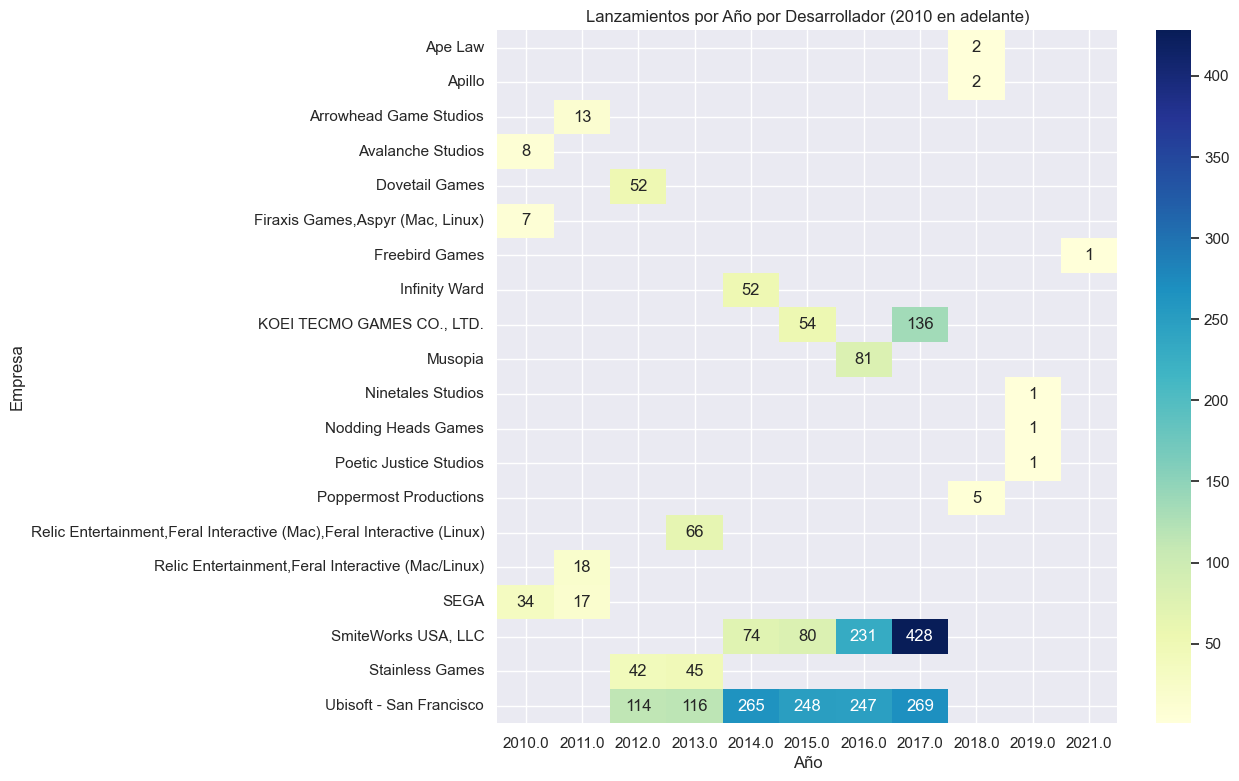

In [ ]:
plt.figure(figsize=(10,9))
heat_map_data = top3_per_year.pivot('developer','year','count')
sns.heatmap(heat_map_data, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Lanzamientos por Año por Desarrollador (2010 en adelante)')
plt.xlabel('Año')
plt.ylabel('Empresa')
plt.show()

In [ ]:
del(top3_per_year,count_per_year_per_developer_filtered,count_per_year_per_developer,developers_per_year_df)

Analicemos ahora algunos aspectos económicos como ser los juegos más caros, los más baratos, la cantidad de juegos pagos y gratis, etc...

In [ ]:
price_df=no_outliers_prices[['price','year','developer','app_name','genres']]

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27870 entries, 88309 to 120442
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      27870 non-null  float64
 1   year       27870 non-null  float64
 2   developer  26770 non-null  object 
 3   app_name   27869 non-null  object 
 4   genres     26775 non-null  object 
dtypes: float64(2), object(3)
memory usage: 1.3+ MB


Agrupamos el dataframe según el año y lo ordenamos de acuerdo al precio más alto para el año.

In [ ]:
price_df=price_df.groupby('year').apply(lambda x: x.sort_values(by='price', ascending=False)).reset_index(drop=True)
price_df

,price,year,developer,app_name,genres
0,24.99,2005.0,Image Space Incorporated,rFactor,"[Racing, Simulation, Sports]"
1,24.99,2005.0,KADOKAWA,RPG Maker XP,[Web Publishing]
2,19.99,2005.0,NovaLogic,Delta Force: Xtreme,[Action]
3,19.99,2005.0,Spiderweb Software,Geneforge 3,"[Strategy, RPG, Indie]"
4,19.99,2005.0,Firaxis Games,Sid Meier's Civilization® IV,[Strategy]
...,...,...,...,...,...
27865,14.99,2019.0,Nodding Heads Games,Raji: An Ancient Epic,"[Action, Adventure, Indie]"
27866,14.99,2019.0,Svarun Entertainment,K'NOSSOS,"[Adventure, Free to Play, Indie]"
27867,14.99,2019.0,Ninetales Studios,The Legendary Player - Make Your Reputation - ...,"[Action, Adventure, Indie, RPG, Strategy, Earl..."
27868,14.99,2019.0,Poetic Justice Studios,The End of an Age: Fading Remnants,[RPG]


In [ ]:
#separamos los juegos gratis
free=price_df[(price_df['price']==0.0)]
not_free=price_df[(price_df['price']!=0.0)]

In [ ]:
max_prices=not_free.groupby('year')['price'].first().reset_index()
max_prices_sorted=max_prices.sort_values(by='year',ascending=False).reset_index(drop=True)
max_prices_sorted

,year,price
0,2021.0,4.99
1,2019.0,14.99
2,2018.0,18.99
3,2017.0,24.99
4,2016.0,24.99
5,2015.0,24.99
6,2014.0,24.99
7,2013.0,24.99
8,2012.0,24.99
9,2011.0,24.99


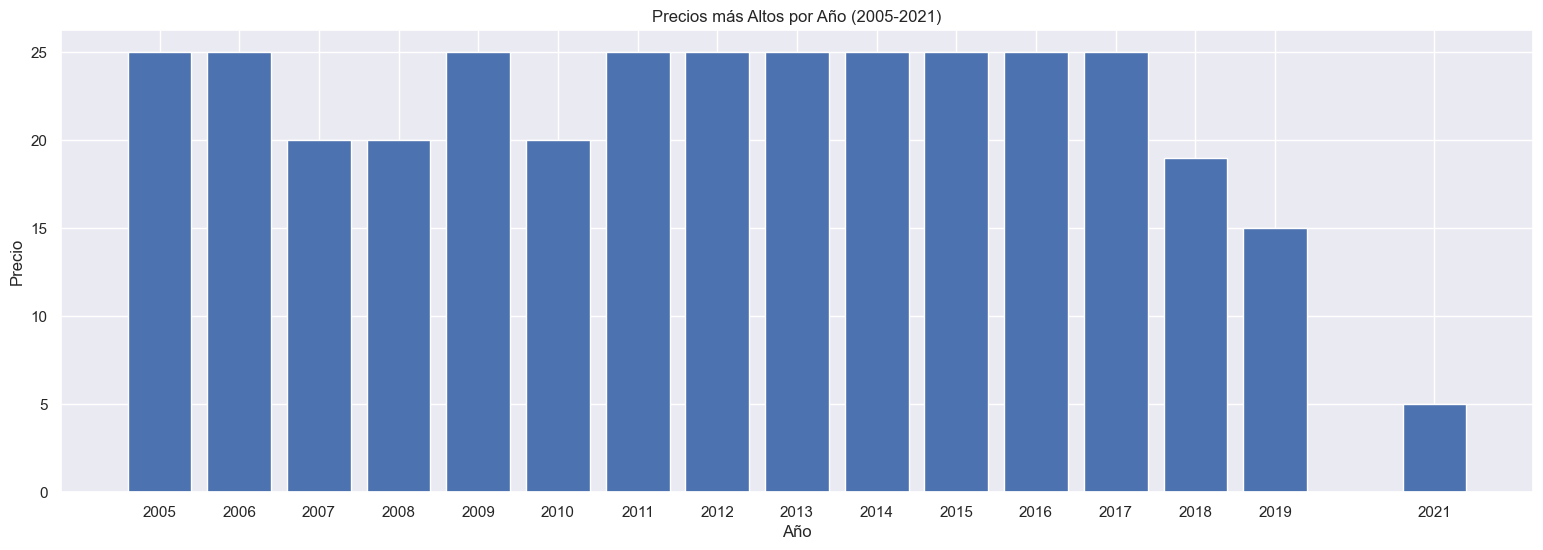

In [ ]:
plt.figure(figsize=(19,6))
plt.bar(x=max_prices_sorted['year'], height=max_prices_sorted['price'])
plt.xticks(max_prices_sorted['year'])
plt.xlabel('Año')
plt.ylabel('Precio')
plt.title('Precios más Altos por Año (2005-2021)')
plt.show()

In [ ]:
del(max_prices,max_prices_sorted)

In [ ]:
free

,price,year,developer,app_name,genres
98,0.0,2005.0,Puny Human,Dystopia,"[Action, Free to Play, Indie]"
99,0.0,2005.0,Synergy Team,Synergy,"[Action, Free to Play]"
100,0.0,2005.0,None,Burning Man: Beyond Black Rock,None
249,0.0,2006.0,Nabi Studios,Toribash,"[Action, Free to Play, Indie, Strategy]"
250,0.0,2006.0,SDEnterNET,NAVYFIELD,"[Free to Play, Massively Multiplayer, Simulati..."
...,...,...,...,...,...
27860,0.0,2018.0,杭州分浪网络科技有限公司,忍者村大战2,"[Action, Free to Play, Massively Multiplayer, ..."
27861,0.0,2018.0,None,Kalen Chock Presents: 2017 Free Tutorial,None
27862,0.0,2018.0,momoStorm Entertainment,Epic Cards Battle 2-Dragons Rising(TCG),"[Adventure, Casual, Free to Play, Strategy, Ea..."
27863,0.0,2018.0,Secret Level SRL,Ironbound,"[Free to Play, Indie, RPG, Strategy]"


In [ ]:
free_per_year=free[['year','price']].groupby('year').count().sort_values(by='price',ascending=False).reset_index()
free_per_year

,year,price
0,2017.0,637
1,2016.0,484
2,2015.0,222
3,2014.0,83
4,2013.0,35
5,2012.0,33
6,2011.0,17
7,2007.0,14
8,2008.0,11
9,2010.0,9


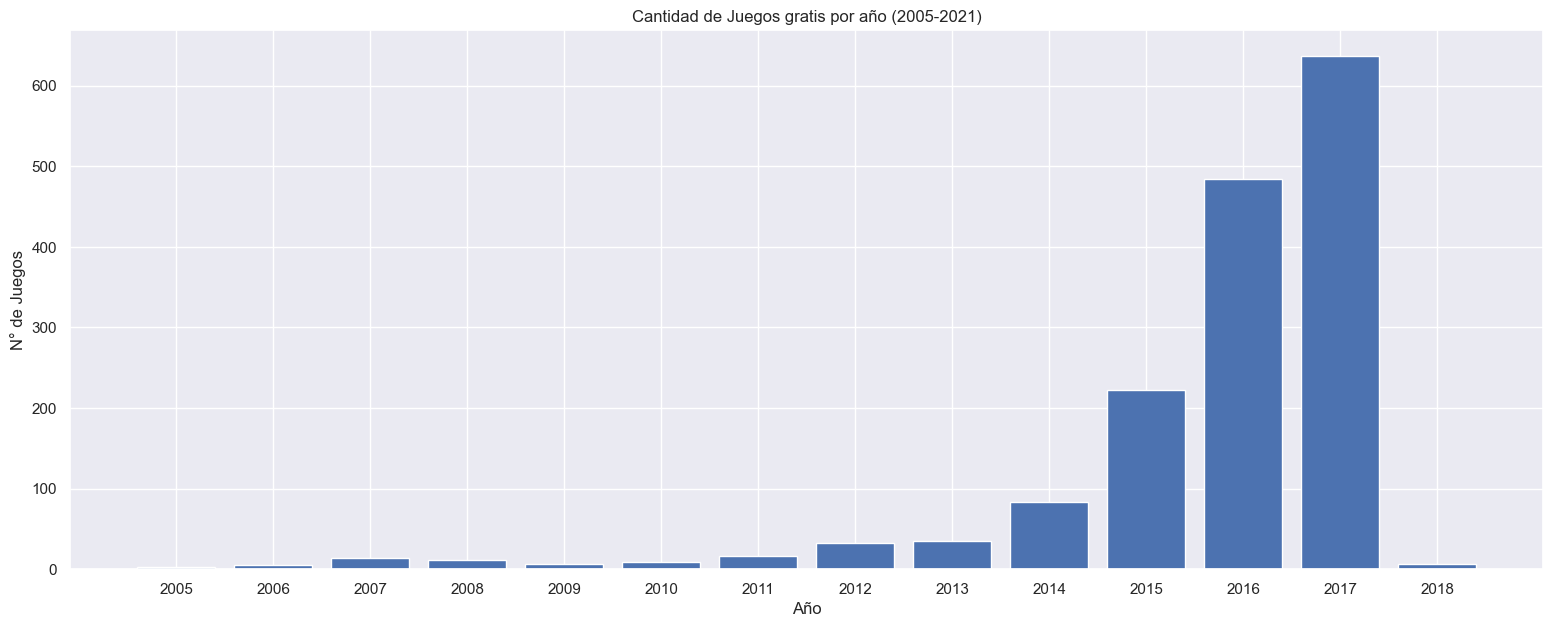

In [ ]:
plt.figure(figsize=(19,7))
plt.bar(x=free_per_year['year'], height=free_per_year['price'])
plt.xticks(free_per_year['year'])
plt.xlabel('Año')
plt.ylabel('N° de Juegos')
plt.title('Cantidad de Juegos gratis por año (2005-2021)')
plt.show()

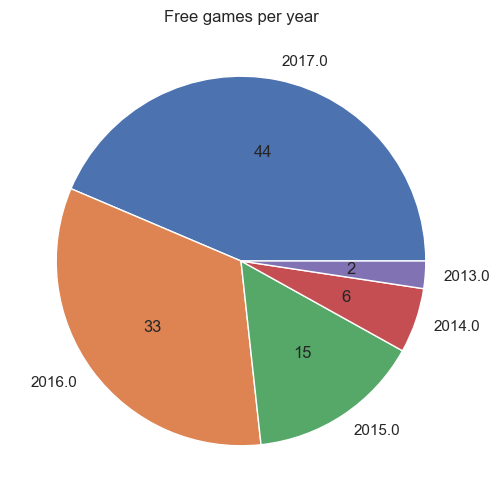

In [ ]:
plt.figure(figsize=(19,6))
plt.pie(x=free_per_year['price'][:5], labels=free_per_year['year'][:5], autopct=lambda x: f'{x:.0f}')
plt.title('Free games per year')
plt.show()

In [ ]:
del(free_per_year)

Juegos gratis por desarrollador

In [ ]:
free_per_developer=free[['developer','year']]
free_per_developer=free_per_developer.groupby('developer')['developer'].count().reset_index(name='Total')
free_per_developer

,developer,Total
0,14 Hours Productions,1
1,2-Volt Games,1
2,"2Chance Projects,IIchan Eroge Team",1
3,4 I Lab,1
4,4th cluster,2
...,...,...
1201,弘原游戏,1
1202,拉貢拉斯找金粒,1
1203,杭州分浪网络科技有限公司,1
1204,深圳市云宙多媒体,1


In [ ]:
free_per_developer=free_per_developer.sort_values(by='Total', ascending=False).reset_index(drop=True)
free_per_developer=free_per_developer.iloc[:10]
free_per_developer

,developer,Total
0,Monster Games,20
1,"KOEI TECMO GAMES CO., LTD.",10
2,Quiet River,9
3,AMPLITUDE Studios,9
4,Milestone S.r.l.,8
5,The Simutrans Team,7
6,Laminar Research,6
7,Futuremark,6
8,Quality Simulations,6
9,The Game Creators,5


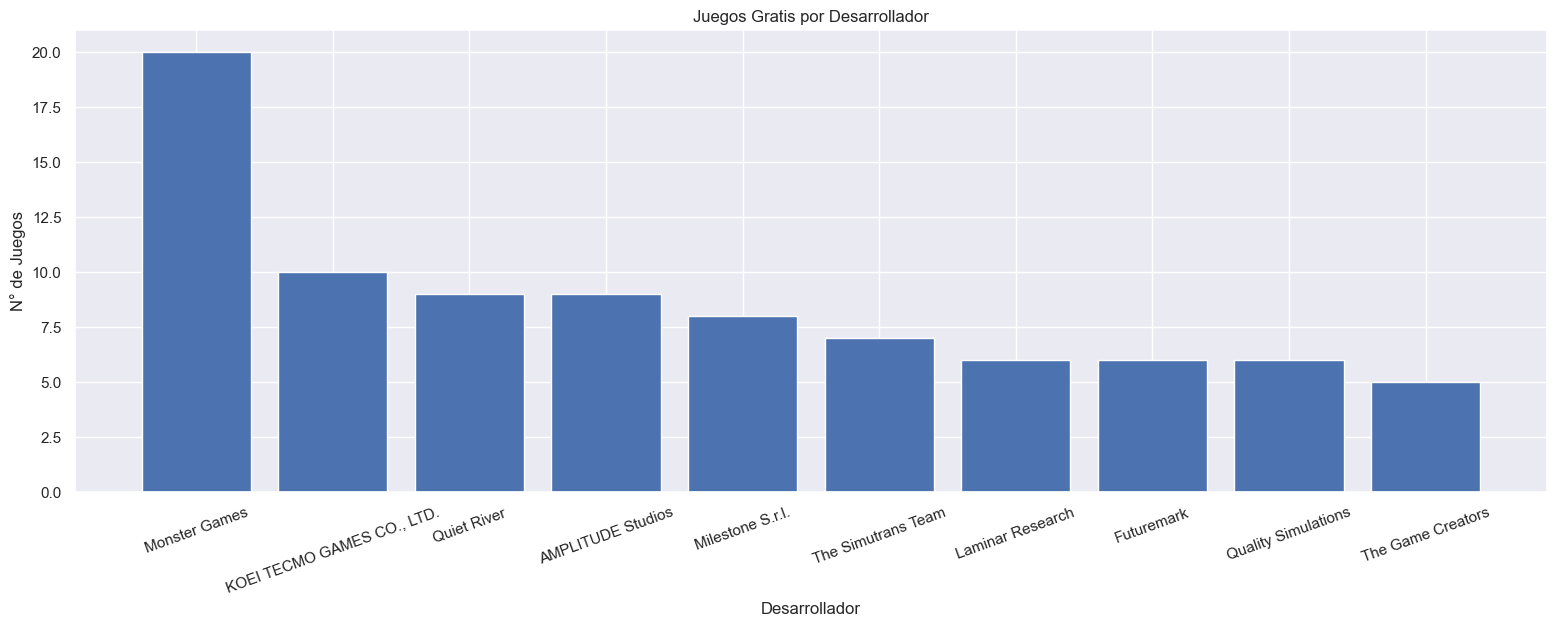

In [ ]:
plt.figure(figsize=(19,6))
plt.bar(x=free_per_developer['developer'], height=free_per_developer['Total'])
plt.xticks(rotation=20)
plt.xlabel('Desarrollador')
plt.ylabel('N° de Juegos')
plt.title('Juegos Gratis por Desarrollador')
plt.show()

In [ ]:
del(free_per_developer)

Analizamos los géneros.

In [ ]:
exploded=not_free.explode('genres')

In [ ]:
precio_promedio_genero=exploded.groupby('genres')['price'].mean().reset_index().sort_values(by='price', ascending=False).reset_index(drop=True)

In [ ]:
precio_promedio_genero

,genres,price
0,Accounting,17.490000
1,Animation &amp; Modeling,13.858691
2,Software Training,13.665842
3,Education,13.339125
4,Web Publishing,13.057346
5,Design &amp; Illustration,12.297405
6,Massively Multiplayer,10.733960
7,Utilities,10.492654
8,Video Production,10.097060
9,Early Access,9.985925


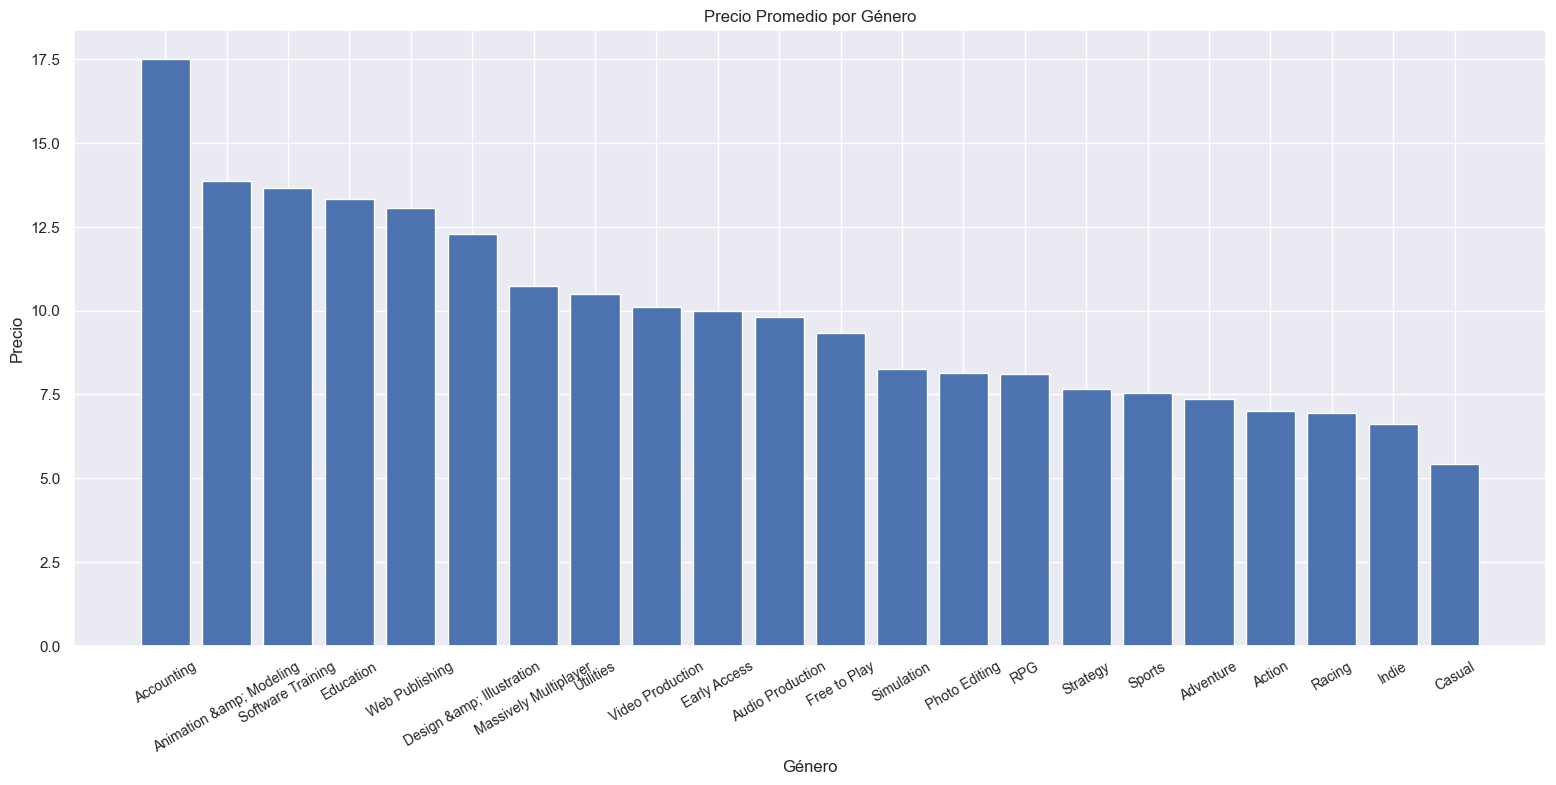

In [ ]:
plt.figure(figsize=(19,8))
plt.bar(x=precio_promedio_genero['genres'], height=precio_promedio_genero['price'])
plt.title('Precio Promedio por Género')
plt.xticks(rotation=30, size=10)
plt.ylabel('Precio')
plt.xlabel('Género')
plt.show()

In [ ]:
gratis_por_genero=free.explode('genres')

In [ ]:
gratis_por_genero=gratis_por_genero['genres'].value_counts().reset_index().set_index('index')
gratis_por_genero = gratis_por_genero.rename(columns={'genres':'count'})

In [ ]:
gratis_por_genero

,count
index,
Indie,862
Free to Play,843
Action,591
Adventure,431
Casual,403
Strategy,362
RPG,357
Simulation,258
Massively Multiplayer,254


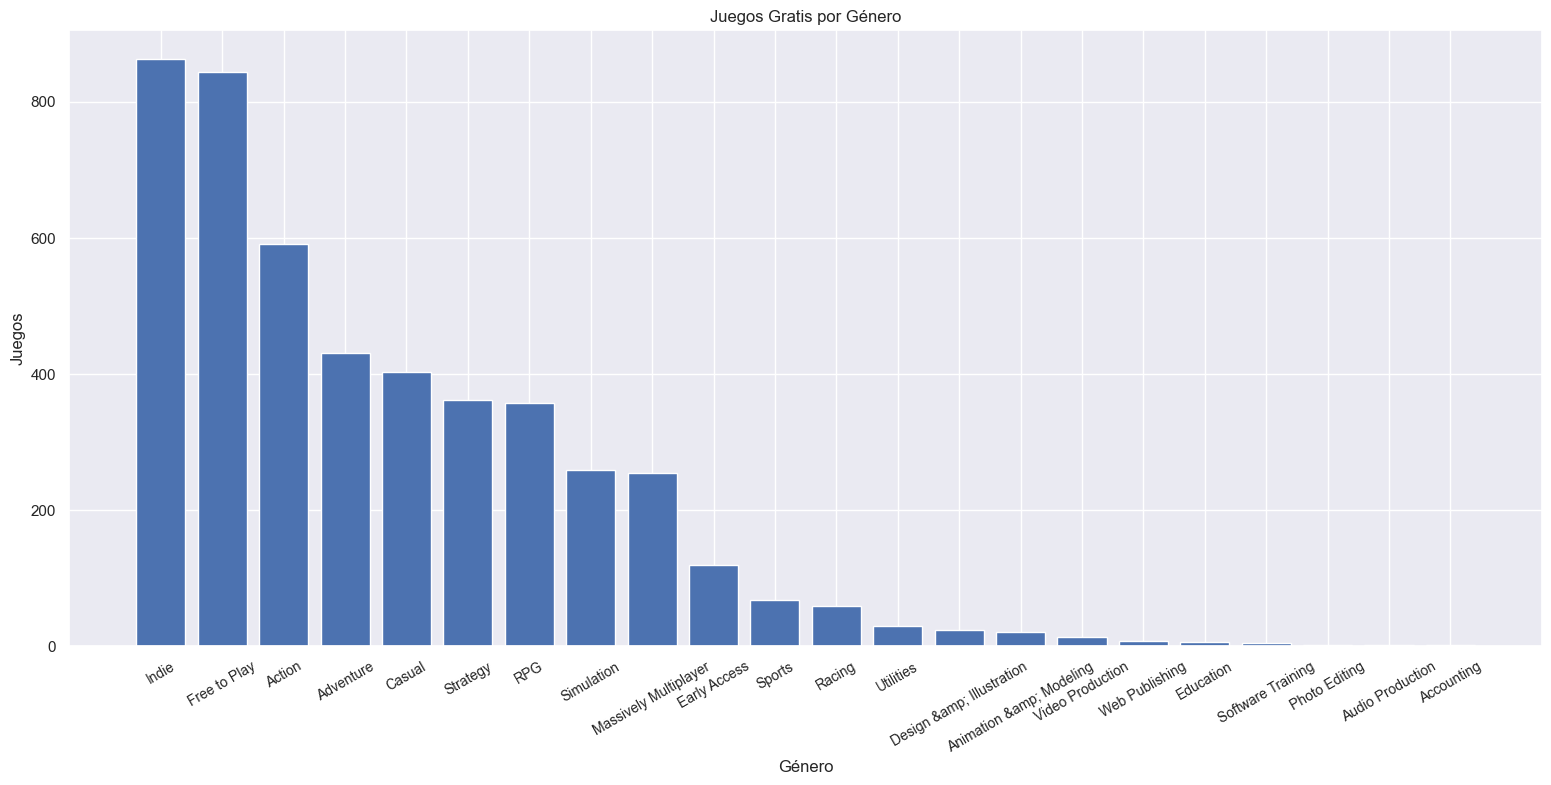

In [ ]:
plt.figure(figsize=(19,8))
plt.bar(x=gratis_por_genero.index, height=gratis_por_genero['count'])
plt.title('Juegos Gratis por Género')
plt.xticks(rotation=30, size=10)
plt.ylabel('Juegos')
plt.xlabel('Género')
plt.show()

In [ ]:
del(free, precio_promedio_genero,precio_promedio_developer, not_free, exploded)

<h1>Analicemos ahora el archivos user_reviews</h1>

Usaremos el dataframe ya listo para analizar y procesar que dejamos en la exploración de archivos. A ese dataframe ya lo normalizamos para que cada reseña aparezca como un registro individual y no todas agrupadas en un solo campo.

In [ ]:
user_reviews_df=pd.read_csv('user_reviews_df.csv')

In [ ]:
user_reviews_df

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted November 5, 2011.",NaN,1250.0,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted July 15, 2011.",NaN,22200.0,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted April 21, 2011.",NaN,43110.0,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,NaN,"Posted June 24, 2014.",NaN,251610.0,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,NaN,"Posted September 8, 2013.",NaN,227300.0,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...,...,...,...,...
59328,76561198312638244,http://steamcommunity.com/profiles/76561198312...,NaN,Posted July 10.,NaN,70.0,No ratings yet,True,a must have classic from steam definitely wort...
59329,76561198312638244,http://steamcommunity.com/profiles/76561198312...,NaN,Posted July 8.,NaN,362890.0,No ratings yet,True,this game is a perfect remake of the original ...
59330,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,1 person found this review funny,Posted July 3.,NaN,273110.0,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...
59331,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,NaN,Posted July 20.,NaN,730.0,No ratings yet,True,:D


In [ ]:
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      59333 non-null  object 
 1   user_url     59333 non-null  object 
 2   funny        8151 non-null   object 
 3   posted       59305 non-null  object 
 4   last_edited  6140 non-null   object 
 5   item_id      59305 non-null  float64
 6   helpful      59305 non-null  object 
 7   recommend    59305 non-null  object 
 8   review       59275 non-null  object 
dtypes: float64(1), object(8)
memory usage: 4.1+ MB


Hay 28 usuarios que no tienen registros sobre ningún item...

In [ ]:
sin_reviews = user_reviews_df[user_reviews_df.drop(['user_id', 'user_url'], axis=1).isna().all(axis=1)]
sin_reviews

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
137,gdxsd,http://steamcommunity.com/id/gdxsd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,76561198094224872,http://steamcommunity.com/profiles/76561198094...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2559,76561198021575394,http://steamcommunity.com/profiles/76561198021...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10080,cmuir37,http://steamcommunity.com/id/cmuir37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13767,Jaysteeny,http://steamcommunity.com/id/Jaysteeny,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15493,ML8989,http://steamcommunity.com/id/ML8989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19184,76561198079215291,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20223,76561198079342142,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25056,76561198061996985,http://steamcommunity.com/profiles/76561198061...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26257,76561198108286351,http://steamcommunity.com/profiles/76561198108...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
usuarios=sin_reviews['user_id'].unique()
len(usuarios)

28

Los usuarios sin registros representan solamente el 0,11% de los usuarios totales.

In [ ]:
(len(usuarios)/len(user_reviews_df['user_id'].unique()))*100

0.10986855012752599

Eliminamos los usuarios sin ningún tipo de registros.

In [ ]:
user_reviews_df = user_reviews_df.drop(sin_reviews.index)

In [ ]:
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59305 entries, 0 to 59332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      59305 non-null  object 
 1   user_url     59305 non-null  object 
 2   funny        8151 non-null   object 
 3   posted       59305 non-null  object 
 4   last_edited  6140 non-null   object 
 5   item_id      59305 non-null  float64
 6   helpful      59305 non-null  object 
 7   recommend    59305 non-null  object 
 8   review       59275 non-null  object 
dtypes: float64(1), object(8)
memory usage: 4.5+ MB


In [ ]:
del(usuarios,sin_reviews)

In [ ]:
not_reviews=user_reviews_df[(user_reviews_df['review'].isna())]
len(not_reviews)

30

Hay 27 usuarios que no tienen reseñas sobre sus items.

In [ ]:
len(not_reviews['user_id'].unique())

27

In [ ]:
del(not_reviews)

In [ ]:
cantidad_usuarios = user_reviews_df['user_id'].value_counts().reset_index()
cantidad_usuarios.rename(columns={'user_id':'count'}, inplace=True)
cantidad_usuarios

,index,count
0,76561198094665607,20
1,dannysfatass,20
2,76561198064484479,20
3,chicken_tonight,20
4,MIMMATA,20
...,...,...
25453,76561198019652792,1
25454,AAAAAAAAlAAAAAAAAAA,1
25455,h00py,1
25456,76561198026959699,1


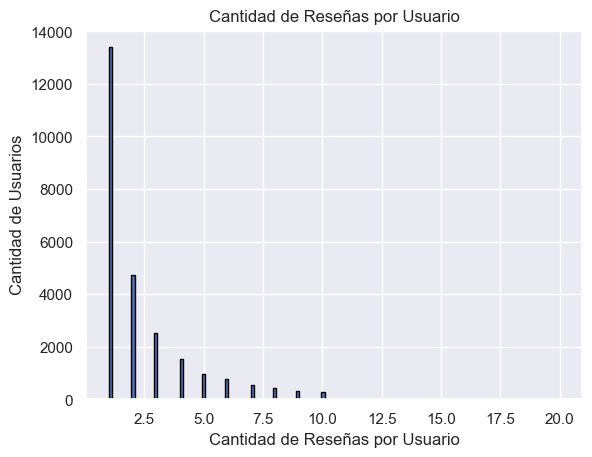

In [ ]:
plt.hist(cantidad_usuarios['count'], bins='auto', edgecolor='black')

plt.xlabel('Cantidad de Reseñas por Usuario')
plt.ylabel('Cantidad de Usuarios')
plt.title('Cantidad de Reseñas por Usuario')

plt.show()

In [ ]:
del(cantidad_usuarios)

La mayoría de los usuarios tienen entre 1 y 2 reseñas.

Vamos a analizar el idioma de las reseñas para saber cuántos idiomas distintos distintos hay y cuál es el idioma más frecuente.
Para ellos utilizamos la librería langid.

In [ ]:
import langid

El método classify de langid devuelve una tupla con el idioma identificado y una puntuación a dicha clasificación.
A nosotros solo nos interesa el idioma, es decir, la primera componente de la tupla.

In [ ]:
result = langid.classify(user_reviews_df.iloc[0]['review'])[0]
print(result)

en


Convertimos las reseñas a string

In [ ]:
user_reviews_df['review'] = user_reviews_df['review'].astype(str)

Las unimos a todas en una sola cadena

In [ ]:
texto = ''.join(user_reviews_df['review'])

In [ ]:
len(texto)

12790174

In [ ]:
import string

Tokenizamos la cadena de texto con todas las reseñas unidas.

In [ ]:
tokens=word_tokenize(texto)

In [ ]:
stop_words=set(stopwords.words('english'))
punctuation=set(string.punctuation)

Eliminamos de la cadena de texto las stopwords en inglés y los signos de puntuación.

In [ ]:
filtered_tokens = [word.lower() for word in tokens if (word.isalnum() and word.lower() not in stop_words and word not in punctuation)]

Creamos un diccionario con la frecuencia de cada palabra.

In [ ]:
freq_dist=FreqDist(filtered_tokens)

Creamos la nube de palabras.

In [ ]:
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(' '.join(filtered_tokens))

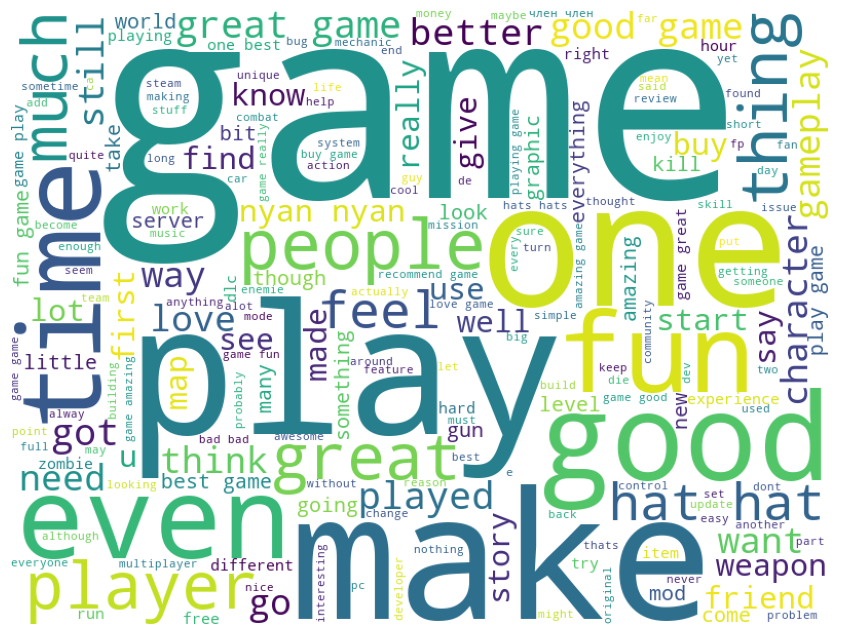

In [ ]:
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
type(freq_dist)

nltk.probability.FreqDist

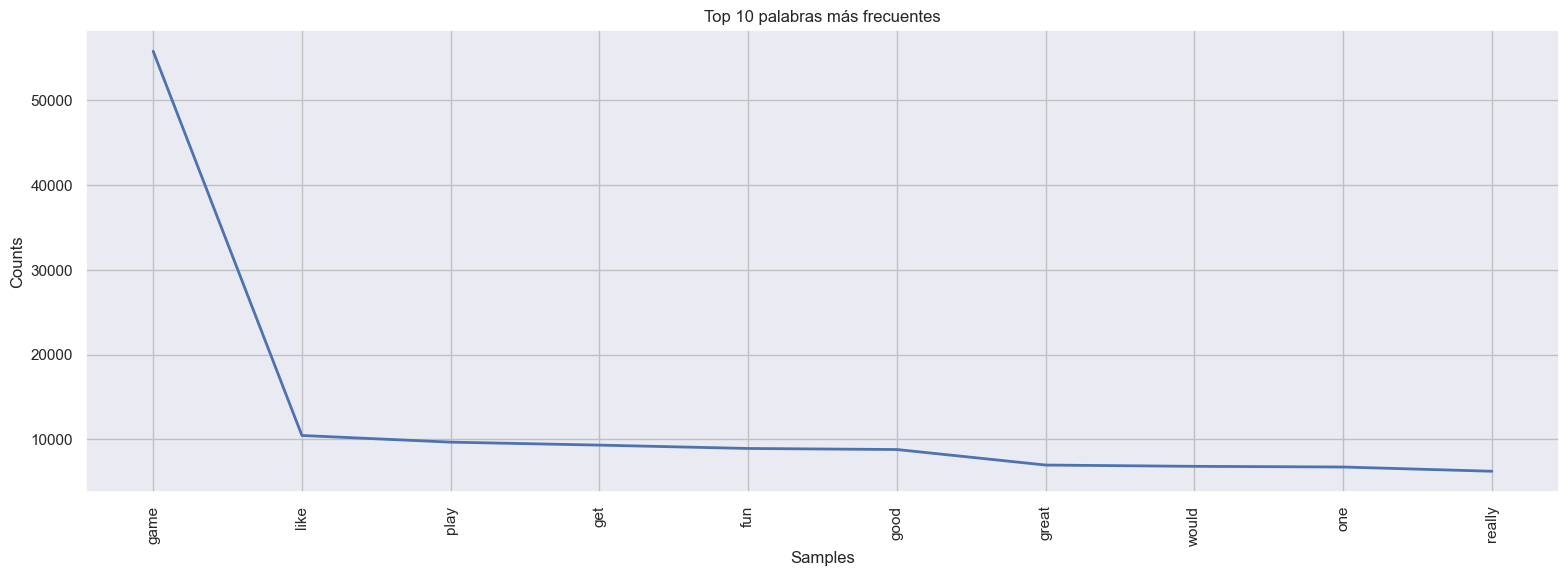

In [ ]:
plt.figure(figsize=(19,6))
freq_dist.plot(10, cumulative=False,title='Top 10 palabras más frecuentes')
plt.show()

Ahora analizaremos el idioma de las reseñas para ver su distribución.

In [ ]:
def reconocedor_language(text):
        lang = langid.classify(text)[0]
        return lang

In [ ]:
user_reviews_df['lang']=user_reviews_df['review'].apply(reconocedor_language)

In [ ]:
user_reviews_df['lang'].value_counts()

en    50527
pt     1800
es     1211
th      712
no      559
      ...  
ky        1
ku        1
ml        1
fa        1
ga        1
Name: lang, Length: 87, dtype: int64

In [ ]:
((user_reviews_df['lang'].value_counts()[0])/(len(user_reviews_df['lang'])))*100

85.19854986931962

In [ ]:
((user_reviews_df['lang'].value_counts()[1])/(len(user_reviews_df['lang'])))*100

3.035157238006913

La mayoría de las reseñas están en inglés. Para ser precisos, un poco más del 85% de las reseñas está en inglés, el segundo idioma más utilizado es el portugues con un 3% y solo el 2% de las reseñas están en español.
Basándonos en esto, nos conviene analizar las reseñas en el idioma inglés y reducir el costo computacional de analizar las reseñas en los otros idiomas.

Eliminamos las stopwords de la columna review.

In [ ]:
def eliminar_stopwords(text, lang):
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        return text

In [ ]:
user_reviews_df['review_words'] = user_reviews_df.apply(lambda row: eliminar_stopwords(row['review'], row['lang']), axis=1)

In [ ]:
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
def analizar_review(reviews:str):
    if type(reviews)!= str:
        return reviews
    #creamos el analizador
    analizador=SentimentIntensityAnalyzer()
    #partimos la review en oraciones
    sentences=tokenizer.tokenize(reviews)
    #creamos los contadores
    negativos=0
    positivos=0
    neutros=0
    #creamos una lista para los compound scores en caso de empate
    compound_scores=[]
    #iteramos sobre las oraciones
    for sentence in sentences:
        #analizamos el sentimiento de la oración
        scores=analizador.polarity_scores(sentence)
        #incrementamos los contadores
        if scores['neg']>0.5:
            negativos+=1
        if scores['pos']>0.5:
            positivos+=1
        if scores['neu']>0.5:
            neutros+=1
        compound_scores.append(scores['compound'])
    
    if max(negativos,positivos,neutros)==negativos:
        calificacion=0
    if max(negativos,positivos,neutros)==neutros:
        calificacion=1
    if max(negativos,positivos,neutros)==positivos:
        calificacion=2
    return calificacion   

In [ ]:
user_reviews_df['sentiment_analysis']=user_reviews_df['review_words'].apply(analizar_review)

In [ ]:
user_reviews_df.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,lang,review_words,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted November 5, 2011.",NaN,1250.0,No ratings yet,True,Simple yet with great replayability. In my opi...,en,Simple yet great replayability . opinion `` zo...,2
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted July 15, 2011.",NaN,22200.0,No ratings yet,True,It's unique and worth a playthrough.,en,'s unique worth playthrough .,1
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted April 21, 2011.",NaN,43110.0,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,en,Great atmosphere . gunplay bit chunky times en...,2
3,js41637,http://steamcommunity.com/id/js41637,NaN,"Posted June 24, 2014.",NaN,251610.0,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,en,know think see title `` Barbie Dreamhouse Part...,1
4,js41637,http://steamcommunity.com/id/js41637,NaN,"Posted September 8, 2013.",NaN,227300.0,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,en,simple ( 's actually simple ! ) truck driving ...,2


Veamos cuantas reseñas de cada categoría tenemos.

In [ ]:
user_reviews_df['sentiment_analysis'].value_counts()

1    35084
2    22599
0     1622
Name: sentiment_analysis, dtype: int64

El 59% de las reseñas son neutrales el 38% son positivas y un poco menos del 3% son negativas.

In [ ]:
(user_reviews_df['sentiment_analysis'].value_counts()[1])/(len(user_reviews_df['sentiment_analysis']))*100

59.15858696568586

In [ ]:
(user_reviews_df['sentiment_analysis'].value_counts()[2])/(len(user_reviews_df['sentiment_analysis']))*100

38.1063991231768

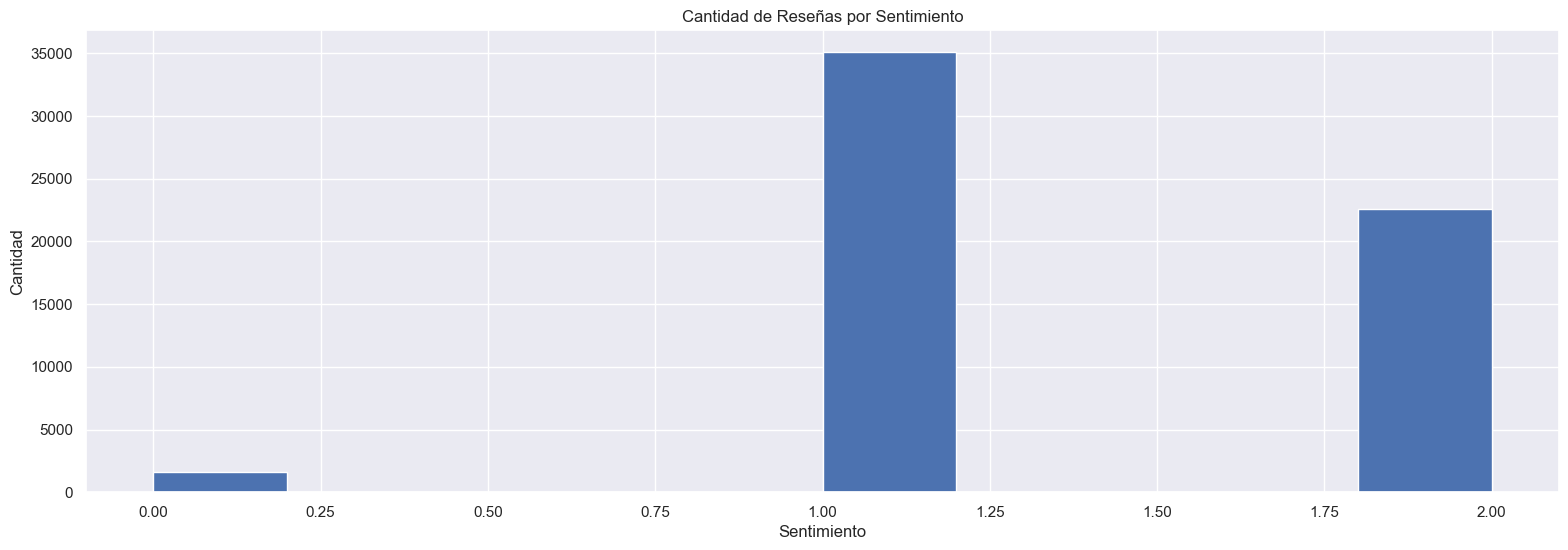

In [ ]:
plt.figure(figsize=(19,6))
plt.hist(user_reviews_df['sentiment_analysis'])
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Cantidad de Reseñas por Sentimiento')
plt.show()